In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
data_path = Path('../data/processed/cup_10_min_aggs.parquet')
assert data_path.exists()

In [3]:
met = pd.read_parquet(data_path)
met.head(3)

Air_Temp_87m                                             \
                           count        max       mean        min       var   
timestamp                                                                     
2018-12-31 17:00:00          600 -15.477113 -15.691004 -15.805410  0.002746   
2018-12-31 17:10:00          600 -15.577877 -15.798286 -15.977685  0.004473   
2018-12-31 17:20:00          600 -15.714396 -16.011219 -16.208467  0.008372   

                    Cup_WS_C1_105m                                         \
                           3s_gust count integrated_low_freq_ke       max   
timestamp                                                                   
2018-12-31 17:00:00       8.805074   600               0.212934  8.917205   
2018-12-31 17:10:00       8.546263   600               0.368811  8.775206   
2018-12-31 17:20:00       8.774642   600               0.196161  8.879639   

                               ... Vane_WD_122m                        \
                         mean  ...        count        max       mean   
timestamp                      ...                                      
2018-12-31 17:00:00  7.490526  ...          600  33.494221  22.310926   
2018-12-31 17:10:00  7.050964  ...          600  31.750303  18.813911   
2018-12-31 17:20:00  7.794179  ...          600  33.310650  18.989834   

                                          Vane_WD_87m                        \
                           min        var       count        max       mean   
timestamp                                                                     
2018-12-31 17:00:00  11.305159  15.657919         600  36.993736  23.034079   
2018-12-31 17:10:00   3.709938  23.281769         600  34.089355  21.583694   
2018-12-31 17:20:00   5.362070  25.907095         600  35.241886  20.046831   

                                           
                           min        var  
timestamp                                  
2018-12-31 17:00:00  10.439404  17.228054  
2018-12-31 17:10:00   3.040152  25.558174  
2018-12-31 17:20:00   2.509987  19.110186  

[3 rows x 34 columns]

# Cross validation under autocorrelation
## Data Leakage
Most time series applications are forecasting problems and are validated via backtesting (simulating forecasts as they would have happened in the past). Forecasts rely on autocorrelation and are vulnerable to data leakage from inappropriate 'future' information relative to the simulated forecast time.

**But this is not a forecasting problem.** I am relying on correlation between features rather than autocorrelation, so there is no concept of 'future' time to worry about.

Instead, my cross validation schema must defend against data leakage from autocorrelation. With temporal autocorrelation, randomly selected points will not provide independent validation of their neighbors, so a simple k-fold CV will drastically overfit the model. To mitigate this, I'll turn to blocked or buffered CVs, which break the autocorrelation structure between train and test sets.

First I need to evaluate the range of the autocorrelation
## Evaluate Autocorrelation range

In [27]:
from statsmodels.tsa.stattools import acf, pacf

In [29]:
def plot_acf(x: pd.Series, nlags, alpha=0.05, partial=False, **kwargs):
    fig, ax = plt.subplots(figsize=(16, 5))
    
    if partial:
        autocorrs, confint = pacf(x.values, nlags=nlags, alpha=alpha, **kwargs)
    else:
        fft = len(x) > 10_000
        autocorrs, confint = acf(x.values, nlags=nlags, fft=fft, alpha=alpha, **kwargs)
    
    ax.plot(np.arange(nlags + 1), autocorrs)
    ax.fill_between(np.arange(nlags + 1), confint[:,0], confint[:,1], alpha=0.3)
    ax.set_xlabel('Lags')
    ax.set_ylabel(f'{"Partial " * partial}Autocorrelation Coef')
    ax.set_title(f'{"Partial " * partial}Autocorrelation Function of {x.name}')
    ax.grid()
    plt.show()

In [50]:
y = met[('Cup_WS_C1_105m', 'integrated_low_freq_ke')]
y.shape

(52560,)

### Day range, 10-minute resolution:

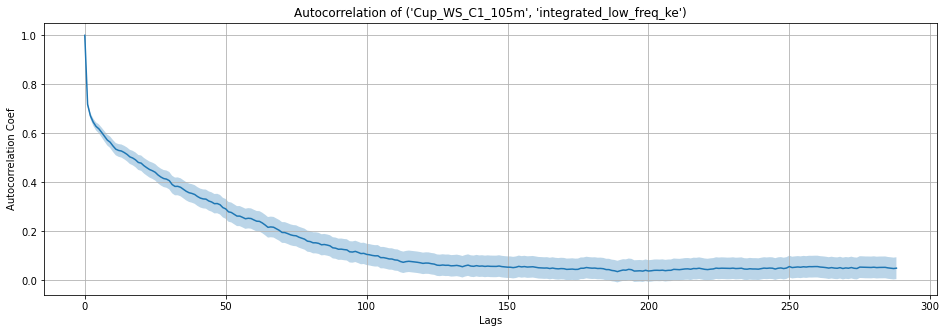

In [51]:
plot_acf(y, 288)

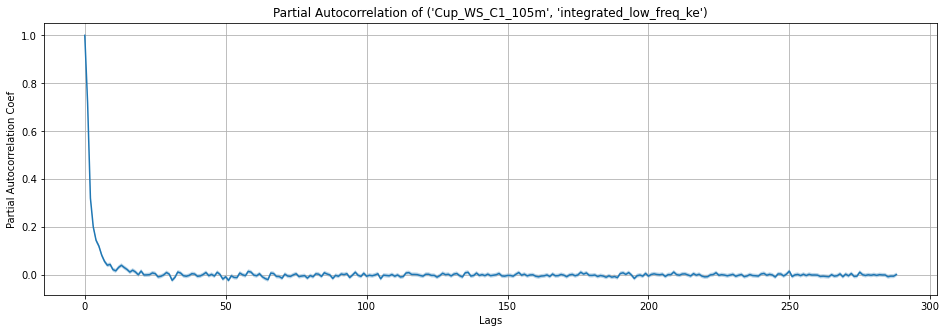

In [52]:
plot_acf(y, 288, partial=True)

### Week range, hourly resolution:

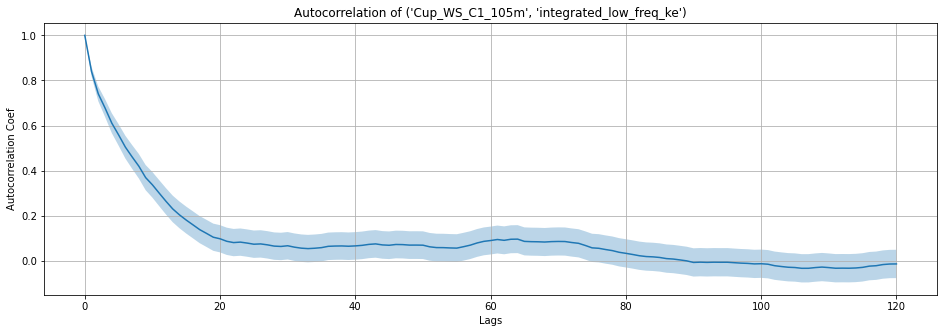

In [53]:
plot_acf(y.resample('1h').mean(), 24*5)

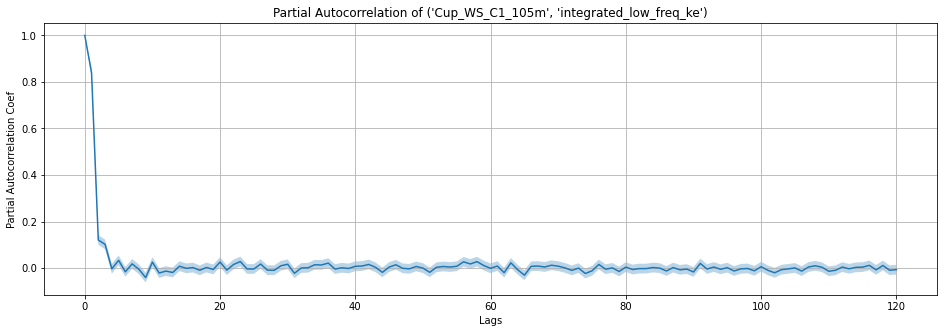

In [54]:
plot_acf(y.resample('1h').mean(), 24*5, partial=True)

### Seasonal range, daily resolution:

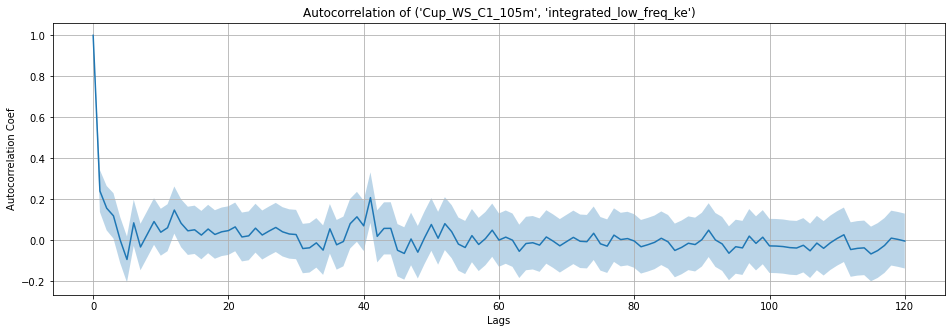

In [55]:
plot_acf(y.resample('1d').mean(), 30*4)

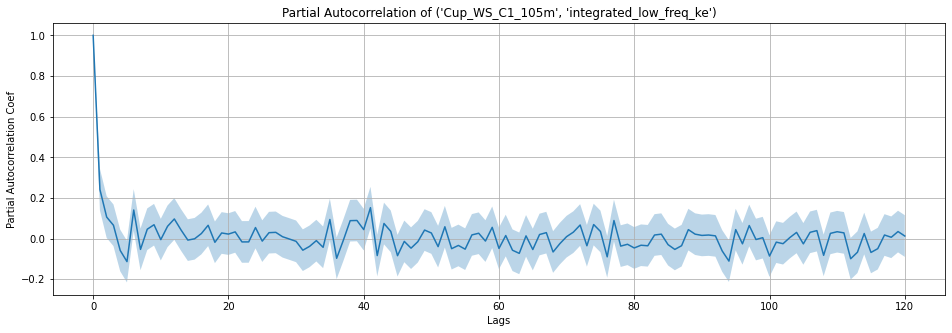

In [56]:
plot_acf(y.resample('1d').mean(), 30*4, partial=True)